In [71]:
# Import statements
%pip install pykrige
%pip install xgboost
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 3.1/72.0 MB 18.4 MB/s eta 0:00:04
   ---- ----------------------------------- 7.3/72.0 MB 19.7 MB/s eta 0:00:04
   ------ --------------------------------- 12.1/72.0 MB 21.0 MB/s eta 0:00:03
   --------- ------------------------------ 16.8/72.0 MB 21.6 MB/s eta 0:00:03
   ----------- ---------------------------- 21.5/72.0 MB 21.6 MB/s eta 0:00:03
   -------------- ------------------------- 26.2/72.0 MB 21.8 MB/s eta 0:00:03
   ----------------- ---------------------- 30.7/72.0 MB 21.9 MB/s eta 0:00:02
   ------------------- -------------------- 35.4/72.0 MB 22.0 MB/s eta 0:00:02
   ---------------------- ----------------- 39.8/72.0 MB 22.0 MB/s eta 0:00:02
   ------------------------ --------------- 44.3/72.0 MB 22.0 MB/s eta 0:00:02
   --------------------------- ------------ 49.0/72.0 MB 22.1 MB/s eta 0:00:

In [74]:
def create_kriging_plot(df, x_col, y_col, z_col, title, cmap='YlOrRd', 
                        add_contours=False, contour_col=None):
    # Extract coordinates and values
    x = df[x_col].values
    y = df[y_col].values
    z = df[z_col].values
    
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]
    
    # Create grid
    grid_x = np.linspace(x.min(), x.max(), 100)
    grid_y = np.linspace(y.min(), y.max(), 100)
    
    # Perform Ordinary Kriging
    OK = OrdinaryKriging(x, y, z, variogram_model='spherical', 
                         verbose=False, enable_plotting=False)
    z_pred, ss = OK.execute('grid', grid_x, grid_y)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_pred.T, extent=[x.min(), x.max(), y.min(), y.max()],
                   origin='lower', cmap=cmap, aspect='auto')
    plt.colorbar(im, ax=ax, label=z_col)
    
    # Add contours if requested
    if add_contours and contour_col is not None:
        contour_z = df[contour_col].values[mask]
        OK_contour = OrdinaryKriging(x, y, contour_z, variogram_model='spherical',
                                     verbose=False, enable_plotting=False)
        contour_pred, _ = OK_contour.execute('grid', grid_x, grid_y)
        
        contours = ax.contour(grid_x, grid_y, contour_pred.T, 
                             colors='black', linewidths=1.5, levels=8)
        ax.clabel(contours, inline=True, fontsize=8)
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(title)
    plt.tight_layout()
    return fig


In [28]:
# Read in file
filename = 'sweetspot_UT_Austin.csv'
df = pd.read_csv(filename)

In [29]:
# Size and top 8 rows in dataset
print('Data size:', df.shape)
df.head(n=8)

Data size: (55, 14)


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,1,PO1_1,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,2,PO1_2,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,3,PO1_3,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,4,PO1_4,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,5,PO1_5,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401
5,6,PO1_6,10272.76,11141.88,0.995444,3.840000e-07,0.071007,0.000168,0.000168,8555.5,2.792220,5,3493.232193,3196.746890
6,7,PO1_7,11430.25,11141.88,0.215019,6.030030e-01,0.069382,0.000162,0.000162,8589.1,0.523657,5,3504.380491,3126.405930
7,8,PO1_8,12877.11,11141.88,0.000000,1.244600e+00,0.074247,0.000270,0.000270,8638.6,0.000000,5,3520.804323,2949.434450


In [30]:
# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

In [31]:
# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]':'oil_prod_mstb',    # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)':'water_prod_bbl',    # Cumulative water production, barrels
    'POROS':'porosity',             # Porosity
    'KX':'perm_x',                  # X permeability
    'KY':'perm_y',                  # Y permeability
    'TD(MD)':'total_depth_md',      # Total depth (measured depth)
    'Cg (mmcf)':'gas_prod_mmcf',    # Gas production, million cubic feet
    'FACIES':'facies',              # Facies
    'P_2020-1-6':'past_pressure',   # Pressure on January 6, 2020
    'P_2029-1-1':'future_pressure'  # Predicted pressure on January 1, 2029
}

df.rename(columns=mappings, inplace=True)

In [32]:
# Print out the amount of missing values
# print((df == 0).sum())
df[(df == 0).any(axis=1)]


# Wells 8 and 9 have extremely low permeability, which explains the low water/oil/gas production

# Wells 27, 28, and 47 have extremely high water production, which may explain the gas

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,facies,past_pressure,future_pressure
7,12877.11,11141.88,0.0,1.24460,0.074247,0.000270,0.000270,8638.6,0.0,5,3520.804323,2949.434450
8,14034.61,11141.88,0.0,1.30679,0.073380,0.000284,0.000284,8684.3,0.0,5,3535.967335,2954.485548
26,14034.61,8537.52,0.0,30.15660,0.116111,0.033130,0.010039,8645.4,0.0,4,3523.060526,2676.168143
27,14034.61,5933.16,0.0,37.77570,0.112872,0.012573,0.012573,8647.7,0.0,4,3523.823653,2694.598799
46,14034.61,3328.80,0.0,87.57740,0.143755,0.038000,0.038000,8691.2,0.0,3,3538.256717,2515.127738


In [33]:
# df.sort_values(by='water_prod_bbl', ascending=False)
# df['water_prod_bbl'] = df['water_prod_bbl'].apply(lambda x: '%.5f' % x)
# df

In [34]:
# Missing value imputation

# Replace 0s with NaN 
df['oil_prod_mstb'] = df['oil_prod_mstb'].replace(0, np.nan)
df['gas_prod_mmcf'] = df['gas_prod_mmcf'].replace(0, np.nan)

# Median imputation (safer than mean due to outliers)
df['oil_prod_mstb'] = df['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median())
df['gas_prod_mmcf'] = df['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median())

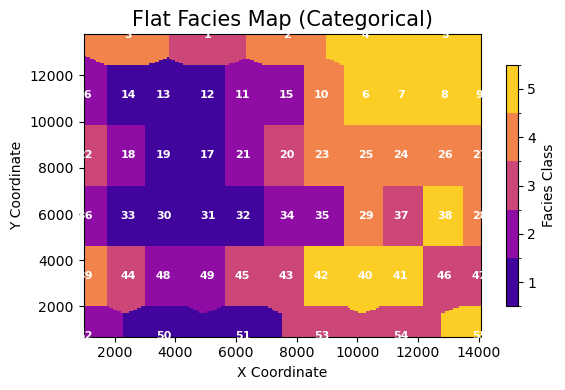

In [35]:
x = df['bh_x']
y = df['bh_y']
c = df['facies']

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use NEAREST interpolation for categorical data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='nearest')

# Define discrete colormap (you can customize colors)
facies_values = np.sort(df['facies'].unique())
n_facies = len(facies_values)
colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_facies))
cmap = ListedColormap(colors)

# Set up discrete normalization boundaries
bounds = np.arange(facies_values.min() - 0.5, facies_values.max() + 1.5, 1)
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, s=40)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(
        xi, yi, str(df.index[i] + 1),  # label = row index
        color='white', fontsize=8, fontweight='bold',
        ha='center', va='center', zorder=4
    )

plt.title('Flat Facies Map (Categorical)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Discrete colorbar with labels for each facies
cbar = plt.colorbar(pcm, shrink=0.8, ticks=facies_values)
cbar.set_label('Facies Class')
plt.tight_layout()
plt.show()


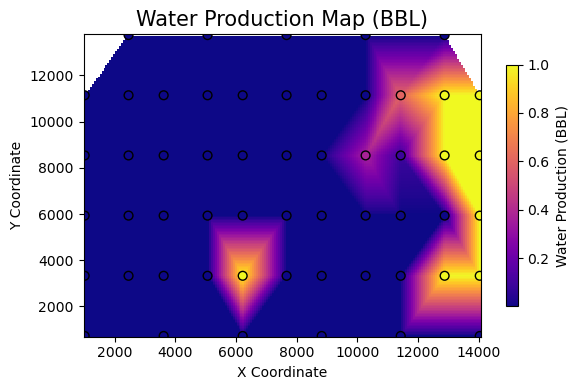

In [36]:
x = df['bh_x']
y = df['bh_y']
c = df['water_prod_bbl']  # continuous variable
c = np.clip(c, 0, 1)

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Water Production Map (BBL)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Water Production (BBL)')
plt.tight_layout()
plt.show()


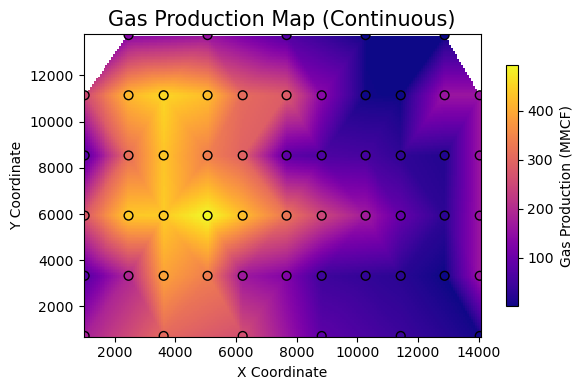

In [37]:
x = df['bh_x']
y = df['bh_y']
c = df['gas_prod_mmcf']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Gas Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Gas Production (MMCF)')
plt.tight_layout()
plt.show()


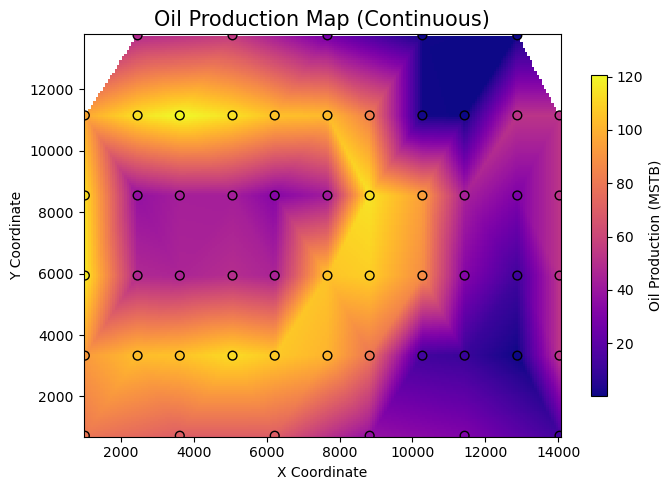

In [38]:
x = df['bh_x']
y = df['bh_y']
c = df['oil_prod_mstb']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Oil Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Oil Production (MSTB)')
plt.tight_layout()
plt.show()


In [39]:
# One-hot encode facies since it is categorical
df = pd.get_dummies(df, columns=['facies'], drop_first=True)

# Rearrange columns: well coordinates, production amounts, rock info, and dates
df = df[['bh_x', 'bh_y', 'total_depth_md', 'oil_prod_mstb', 'water_prod_bbl', 'gas_prod_mmcf', 'perm_x', 'perm_y', 'porosity', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'past_pressure', 'future_pressure']]
df.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,perm_x,perm_y,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure
0,5064.04,13746.23,8551.7,55.191600,1.617450e-04,157.119447,0.020377,0.020377,0.128029,False,True,False,False,3491.971374,2992.403113
1,7668.40,13746.23,8579.9,27.529400,1.394790e-04,69.831076,0.015088,0.015088,0.101876,False,False,True,False,3501.327981,2947.374808
2,2459.67,13746.23,8557.1,48.354000,1.973990e-04,134.781940,0.022396,0.022396,0.119220,False,False,True,False,3493.763065,2904.053641
3,10272.76,13746.23,8635.5,0.572057,1.440000e-07,1.101210,0.000091,0.000091,0.064132,False,False,False,True,3519.775759,3301.826052
4,12877.11,13746.23,8718.6,0.430394,8.560000e-08,0.435085,0.000067,0.000067,0.063078,False,False,False,True,3547.347889,3365.597401


In [40]:
# missing = df[(df == 0).any(axis=1)]
# missing

C:\Users\shake\AppData\Local\Temp\ipykernel_69952\1786411911.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df, labels=df.columns)


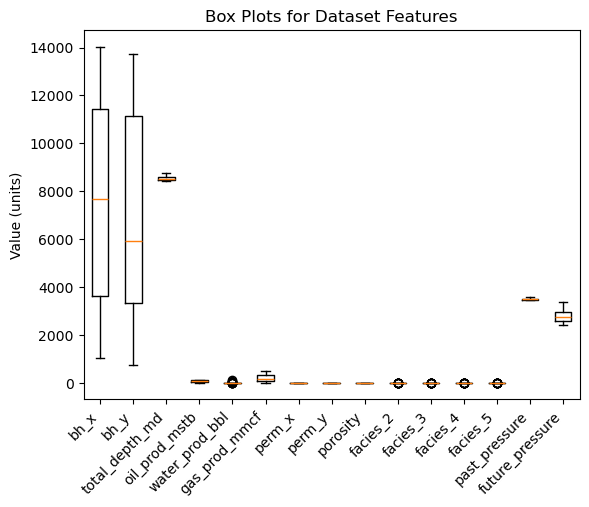

In [41]:
# Boxplots to check for outliers
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (units)')
plt.title('Box Plots for Dataset Features')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_69952\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


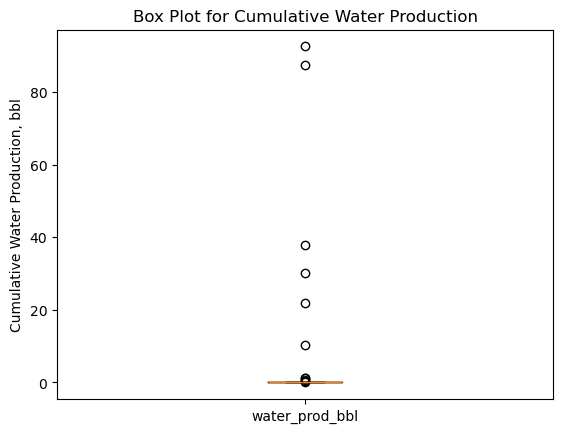

In [42]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

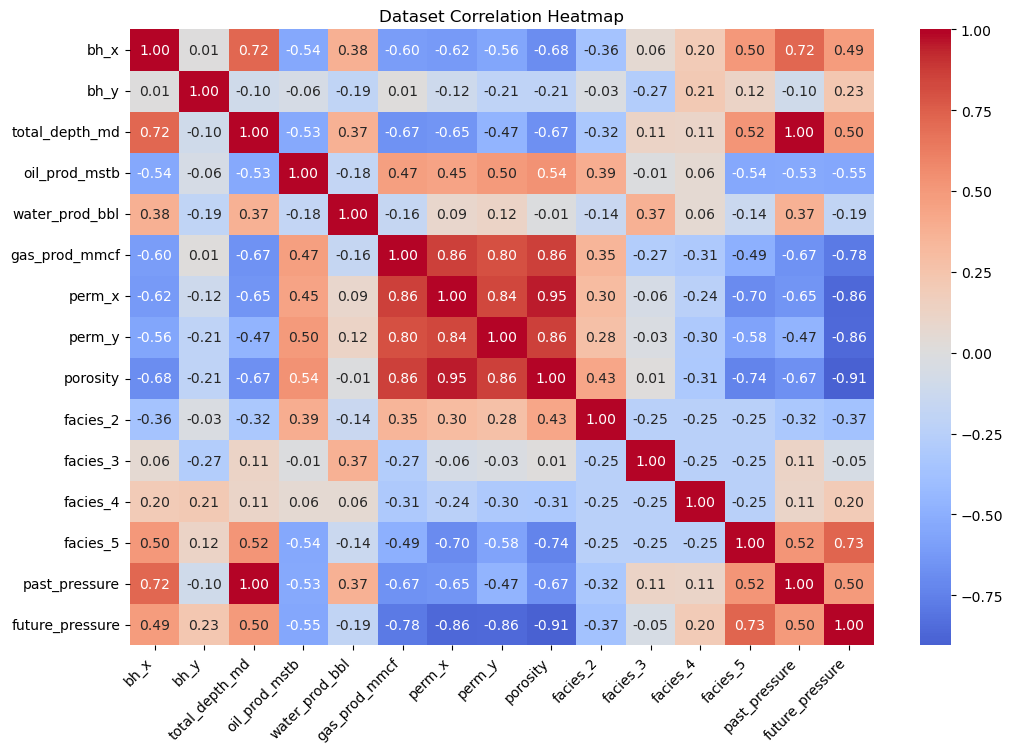

In [43]:
# Heatmap to display correlations
correlation_matrix = df.corr()
# correlation_matrix = correlation_matrix[['oil_prod_mstb']]
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Dataset Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

In [44]:
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
print(perm)

0     0.020377
1     0.015088
2     0.022396
3     0.000091
4     0.000067
5     0.000168
6     0.000162
7     0.000270
8     0.000284
9     0.015151
10    0.038947
11    0.050873
12    0.056463
13    0.052861
14    0.037831
15    0.034999
16    0.027062
17    0.019848
18    0.024499
19    0.013012
20    0.021804
21    0.012884
22    0.012158
23    0.004877
24    0.008402
25    0.009065
26    0.015409
27    0.012573
28    0.022922
29    0.053718
30    0.058151
31    0.047167
32    0.050863
33    0.036493
34    0.030338
35    0.038392
36    0.013927
37    0.004137
38    0.009499
39    0.003991
40    0.002784
41    0.004627
42    0.017898
43    0.026014
44    0.038956
45    0.038350
46    0.038000
47    0.041674
48    0.042639
49    0.055685
50    0.044984
51    0.034241
52    0.016377
53    0.012992
54    0.004627
dtype: float64


In [45]:
# Add harmonic mean permeability to dataframe
df['perm_hm'] = perm
df.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,perm_x,perm_y,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure,perm_hm
0,5064.04,13746.23,8551.7,55.191600,1.617450e-04,157.119447,0.020377,0.020377,0.128029,False,True,False,False,3491.971374,2992.403113,0.020377
1,7668.40,13746.23,8579.9,27.529400,1.394790e-04,69.831076,0.015088,0.015088,0.101876,False,False,True,False,3501.327981,2947.374808,0.015088
2,2459.67,13746.23,8557.1,48.354000,1.973990e-04,134.781940,0.022396,0.022396,0.119220,False,False,True,False,3493.763065,2904.053641,0.022396
3,10272.76,13746.23,8635.5,0.572057,1.440000e-07,1.101210,0.000091,0.000091,0.064132,False,False,False,True,3519.775759,3301.826052,0.000091
4,12877.11,13746.23,8718.6,0.430394,8.560000e-08,0.435085,0.000067,0.000067,0.063078,False,False,False,True,3547.347889,3365.597401,0.000067


In [46]:
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 'total_depth_md', 'water_prod_bbl']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Scale the relevant columns between 0 and 1
scale = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scale.fit_transform(df[columns_to_scale])

In [47]:
df_scaled.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,perm_x,perm_y,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure,perm_hm
0,5064.04,13746.23,0.353722,0.456891,1.745744e-06,0.317443,0.020377,0.020377,0.511559,False,True,False,False,3491.971374,2992.403113,0.349677
1,7668.40,13746.23,0.435084,0.227703,1.505296e-06,0.140991,0.015088,0.015088,0.305572,False,False,True,False,3501.327981,2947.374808,0.258610
2,2459.67,13746.23,0.369302,0.400240,2.130768e-06,0.272288,0.022396,0.022396,0.442178,False,False,True,False,3493.763065,2904.053641,0.384431
3,10272.76,13746.23,0.595499,0.004355,6.306559e-10,0.002056,0.000091,0.000091,0.008303,False,False,False,True,3519.775759,3301.826052,0.000422
4,12877.11,13746.23,0.835257,0.003181,0.000000e+00,0.000709,0.000067,0.000067,0.000000,False,False,False,True,3547.347889,3365.597401,0.000000


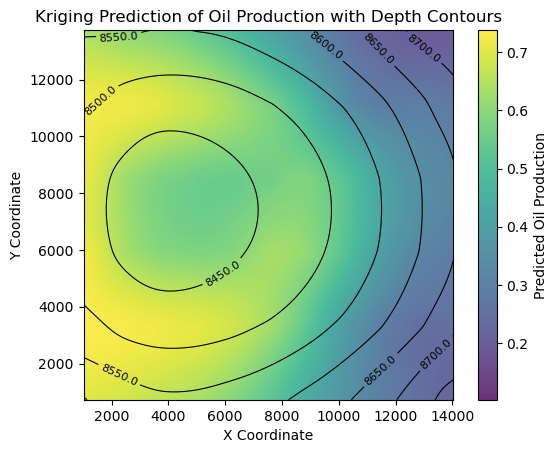

In [48]:
# Kriging interpolation and contour plotting (Oil Production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
oil_prod = df_scaled['oil_prod_mstb']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for oil production
OK_oil = OrdinaryKriging(x, y, oil_prod, variogram_model='linear')
z_oil_pred, ss_oil = OK_oil.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot oil production predicted surface
plt.imshow(z_oil_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Oil Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Oil Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

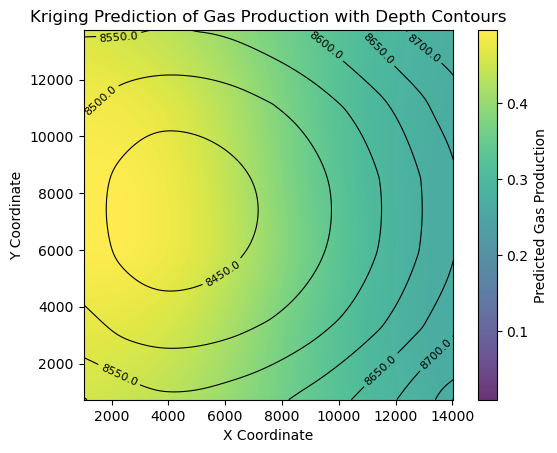

In [49]:
# Kriging interpolation and contour plotting (Gas Production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
gas_prod = df_scaled['gas_prod_mmcf']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for oil production
OK_gas = OrdinaryKriging(x, y, gas_prod, variogram_model='linear')
z_gas_pred, ss_gas = OK_gas.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot oil production predicted surface
plt.imshow(z_gas_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Gas Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Gas Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

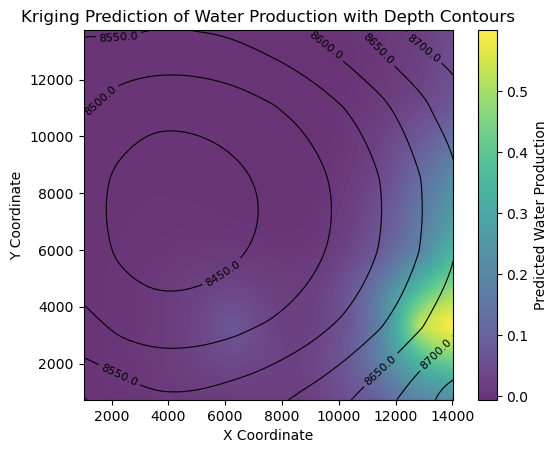

In [50]:
# Kriging interpolation and contour plotting (Water production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
water_prod = df_scaled['water_prod_bbl']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for water production
OK_water = OrdinaryKriging(x, y, water_prod, variogram_model='linear')
z_water_pred, ss_water = OK_water.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot water production predicted surface
plt.imshow(z_water_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Water Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Water Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [51]:
# Define top-performing wells (top quartile)
top_oil_threshold = df['oil_prod_mstb'].quantile(0.75)
top_gas_threshold = df['gas_prod_mmcf'].quantile(0.75)

df['top_oil_well'] = df['oil_prod_mstb'] >= top_oil_threshold
df['top_gas_well'] = df['gas_prod_mmcf'] >= top_gas_threshold

# Facies contribution in top wells
facies_cols = ['facies_2', 'facies_3', 'facies_4', 'facies_5']
print('Facies (sums in top oil wells:')
print(df.loc[df['top_oil_well'], facies_cols].sum())
print('Facies sums in top gas wells:')
print(df.loc[df['top_gas_well'], facies_cols].sum())

Facies (sums in top oil wells:
facies_2    7
facies_3    3
facies_4    1
facies_5    0
dtype: int64
Facies sums in top gas wells:
facies_2    5
facies_3    0
facies_4    0
facies_5    0
dtype: int64


In [52]:
# Porosity & permeability stats in top wells
print('\nPorosity in top oil wells:')
print(df[df['top_oil_well']]['porosity'].describe())
print('\nPermeability in top oil wells:')
print(df[df['top_oil_well']]['perm_hm'].describe())



Porosity in top oil wells:
count    14.000000
mean      0.164826
std       0.020093
min       0.117819
25%       0.158312
50%       0.169857
75%       0.176481
max       0.188017
Name: porosity, dtype: float64

Permeability in top oil wells:
count    14.000000
mean      0.036894
std       0.013158
min       0.012158
25%       0.031877
50%       0.038669
75%       0.042398
max       0.056463
Name: perm_hm, dtype: float64


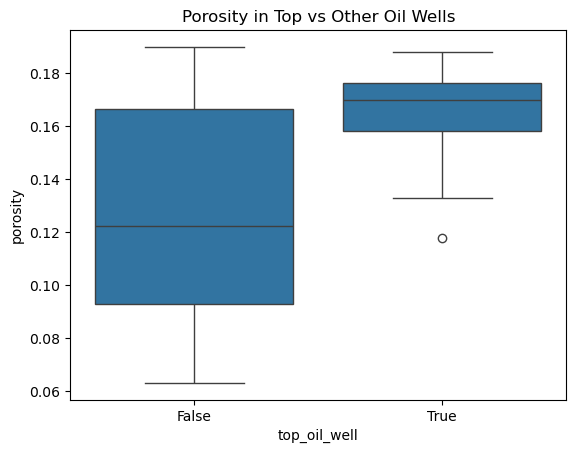

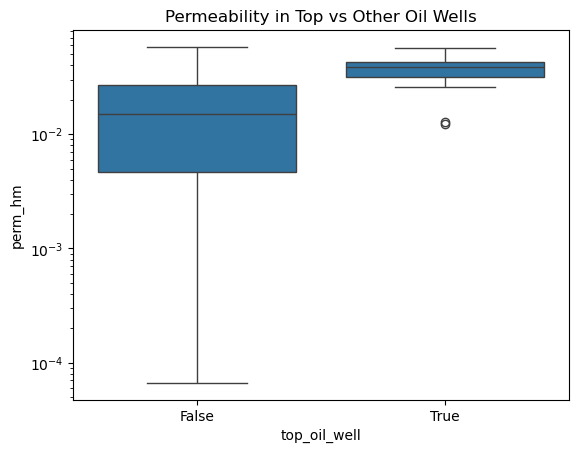

In [53]:
# Visualize distributions
sns.boxplot(data=df, x='top_oil_well', y='porosity')
plt.title('Porosity in Top vs Other Oil Wells')
plt.show()

sns.boxplot(data=df, x='top_oil_well', y='perm_hm')
plt.yscale('log')
plt.title('Permeability in Top vs Other Oil Wells')
plt.show()

In [54]:
# Display top 5 wells by oil production
top_wells = df.nlargest(5, 'oil_prod_mstb')[['bh_x', 'bh_y', 'oil_prod_mstb', 'gas_prod_mmcf',
                                             'perm_hm', 'porosity', 'total_depth_md', 'past_pressure'] + facies_cols]
print(top_wells)

       bh_x      bh_y  oil_prod_mstb  gas_prod_mmcf   perm_hm  porosity  \
12  3617.17  11141.88      120.74300     455.032070  0.056463  0.188017   
35  1012.81   5933.16      116.33900     281.897025  0.038392  0.174661   
22  8825.89   8537.52      114.57856      64.086067  0.012158  0.117819   
11  5064.04  11141.88      113.90400     424.497427  0.050873  0.184044   
13  2459.67  11141.88      113.85100     417.537157  0.052861  0.185201   

    total_depth_md  past_pressure  facies_2  facies_3  facies_4  facies_5  
12          8467.9    3464.166989     False     False     False     False  
35          8474.8    3466.456371      True     False     False     False  
22          8482.4    3468.978010     False     False      True     False  
11          8471.7    3465.427808     False     False     False     False  
13          8477.1    3467.219499     False     False     False     False  


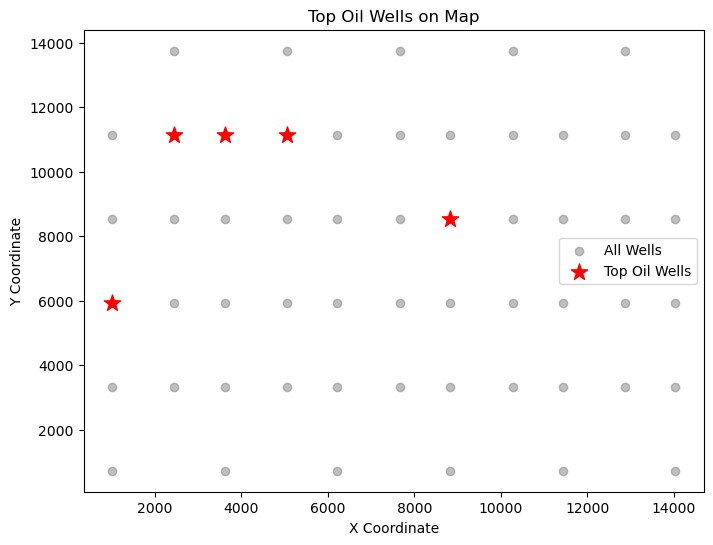

In [55]:
# Plot top oil wells on map
plt.figure(figsize=(8, 6))
plt.scatter(df['bh_x'], df['bh_y'], c='gray', alpha=0.5, label='All Wells')
plt.scatter(top_wells['bh_x'], top_wells['bh_y'], c='r', marker='*', s=150, label='Top Oil Wells')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Top Oil Wells on Map')
plt.legend()
plt.show()

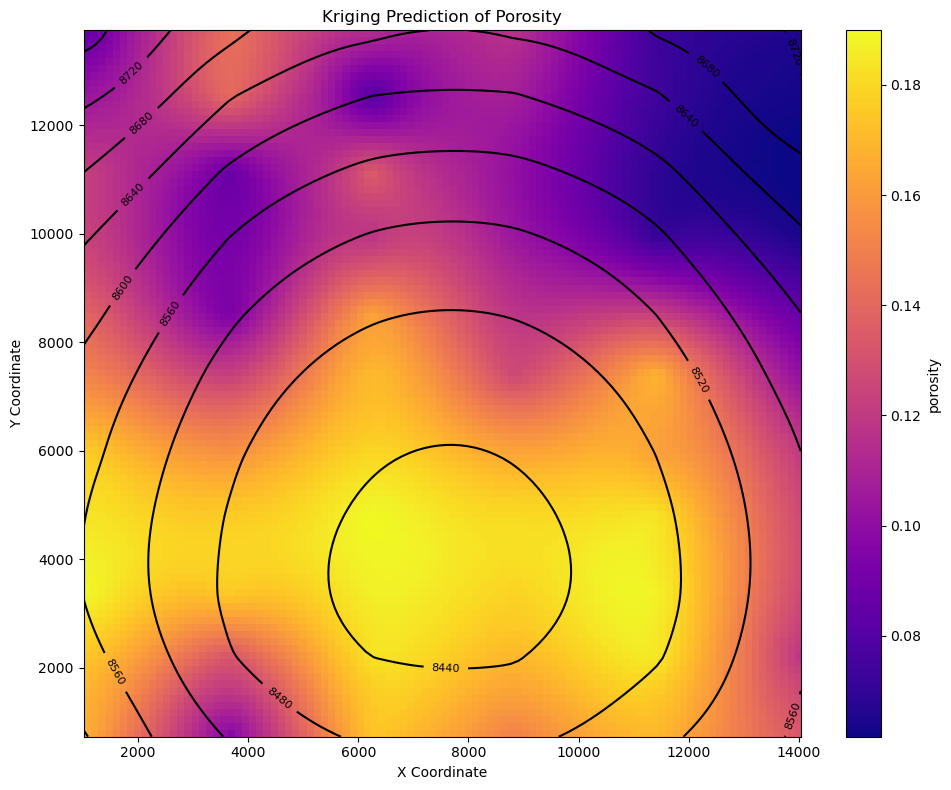

In [62]:
# Kriging plot for porosity
create_kriging_plot(df, 'bh_x', 'bh_y', 'porosity', 
                    'Kriging Prediction of Porosity',
                    cmap='plasma', add_contours=True, contour_col='total_depth_md')
plt.show()

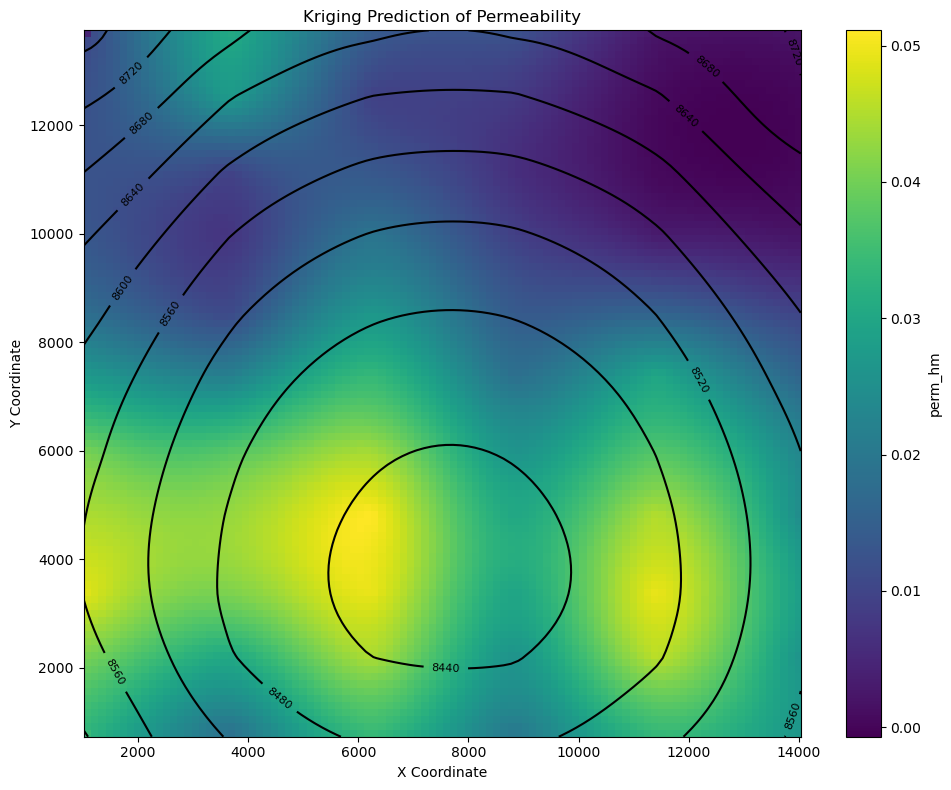

In [63]:
# Kriging plot for permeability
create_kriging_plot(df, 'bh_x', 'bh_y', 'perm_hm', 
                    'Kriging Prediction of Permeability',
                    cmap='viridis', add_contours=True, contour_col='total_depth_md')
plt.show()

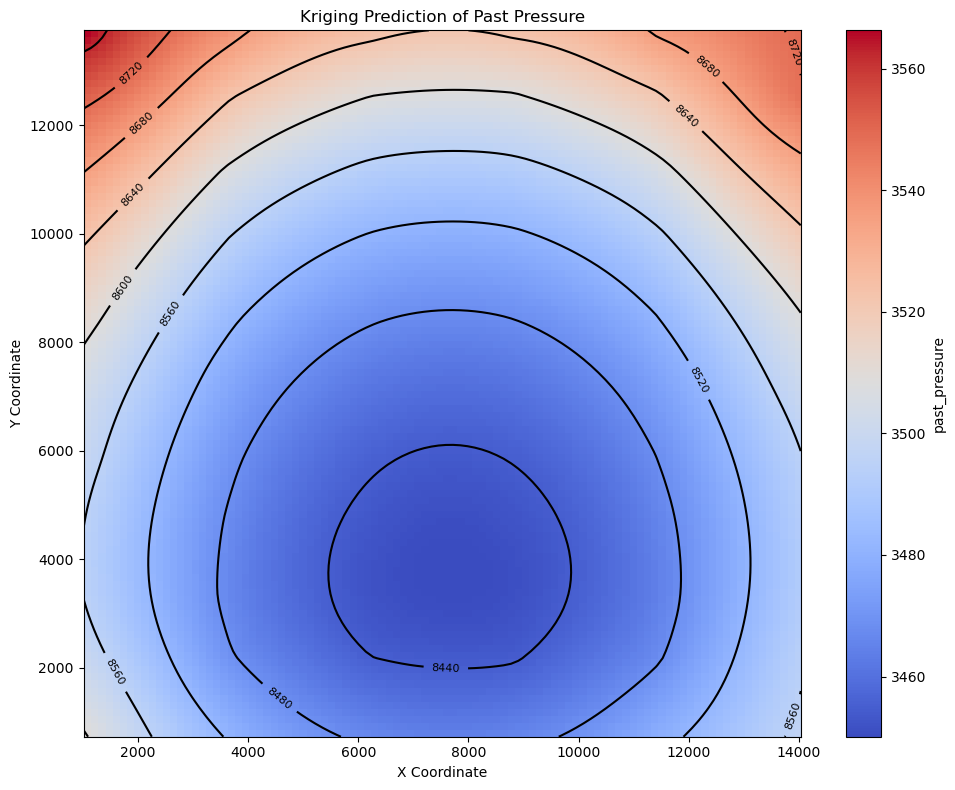

In [64]:
# Kriging plot for past pressure
create_kriging_plot(df, 'bh_x', 'bh_y', 'past_pressure', 
                    'Kriging Prediction of Past Pressure',
                    cmap='coolwarm', add_contours=True, contour_col='total_depth_md')
plt.show()

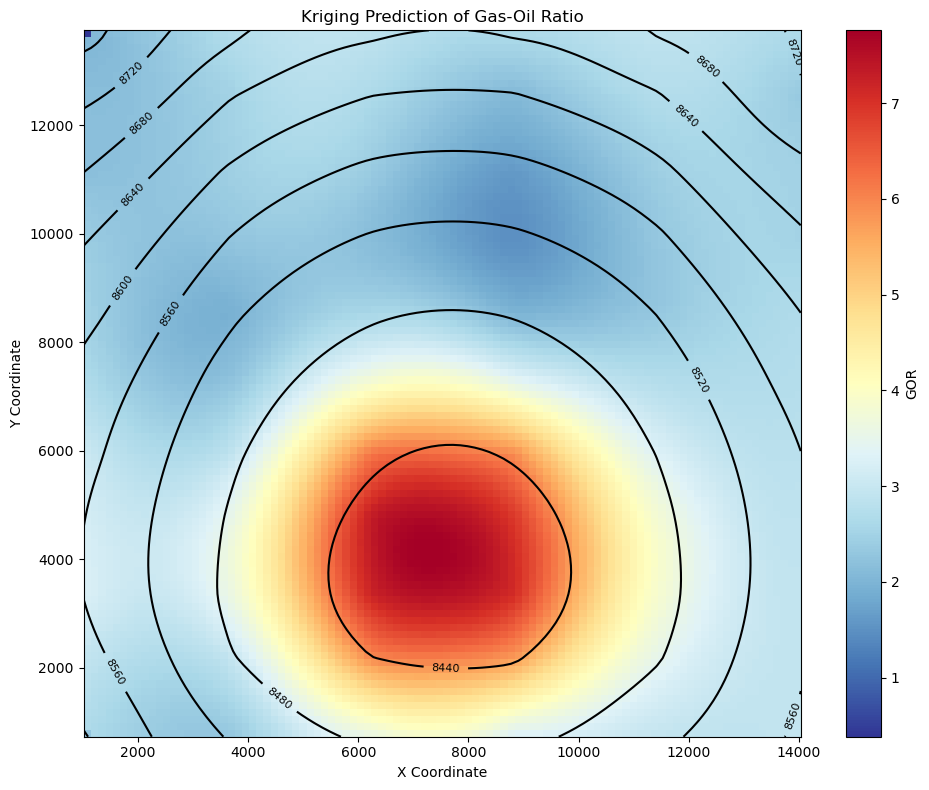

In [65]:
# Classify wells by fluid dominance using GOR
df['GOR'] = df['gas_prod_mmcf'] / (df['oil_prod_mstb'] + 0.001)
create_kriging_plot(df, 'bh_x', 'bh_y', 'GOR', 
                    'Kriging Prediction of Gas-Oil Ratio',
                    cmap='RdYlBu_r', add_contours=True, contour_col='total_depth_md')
plt.show()

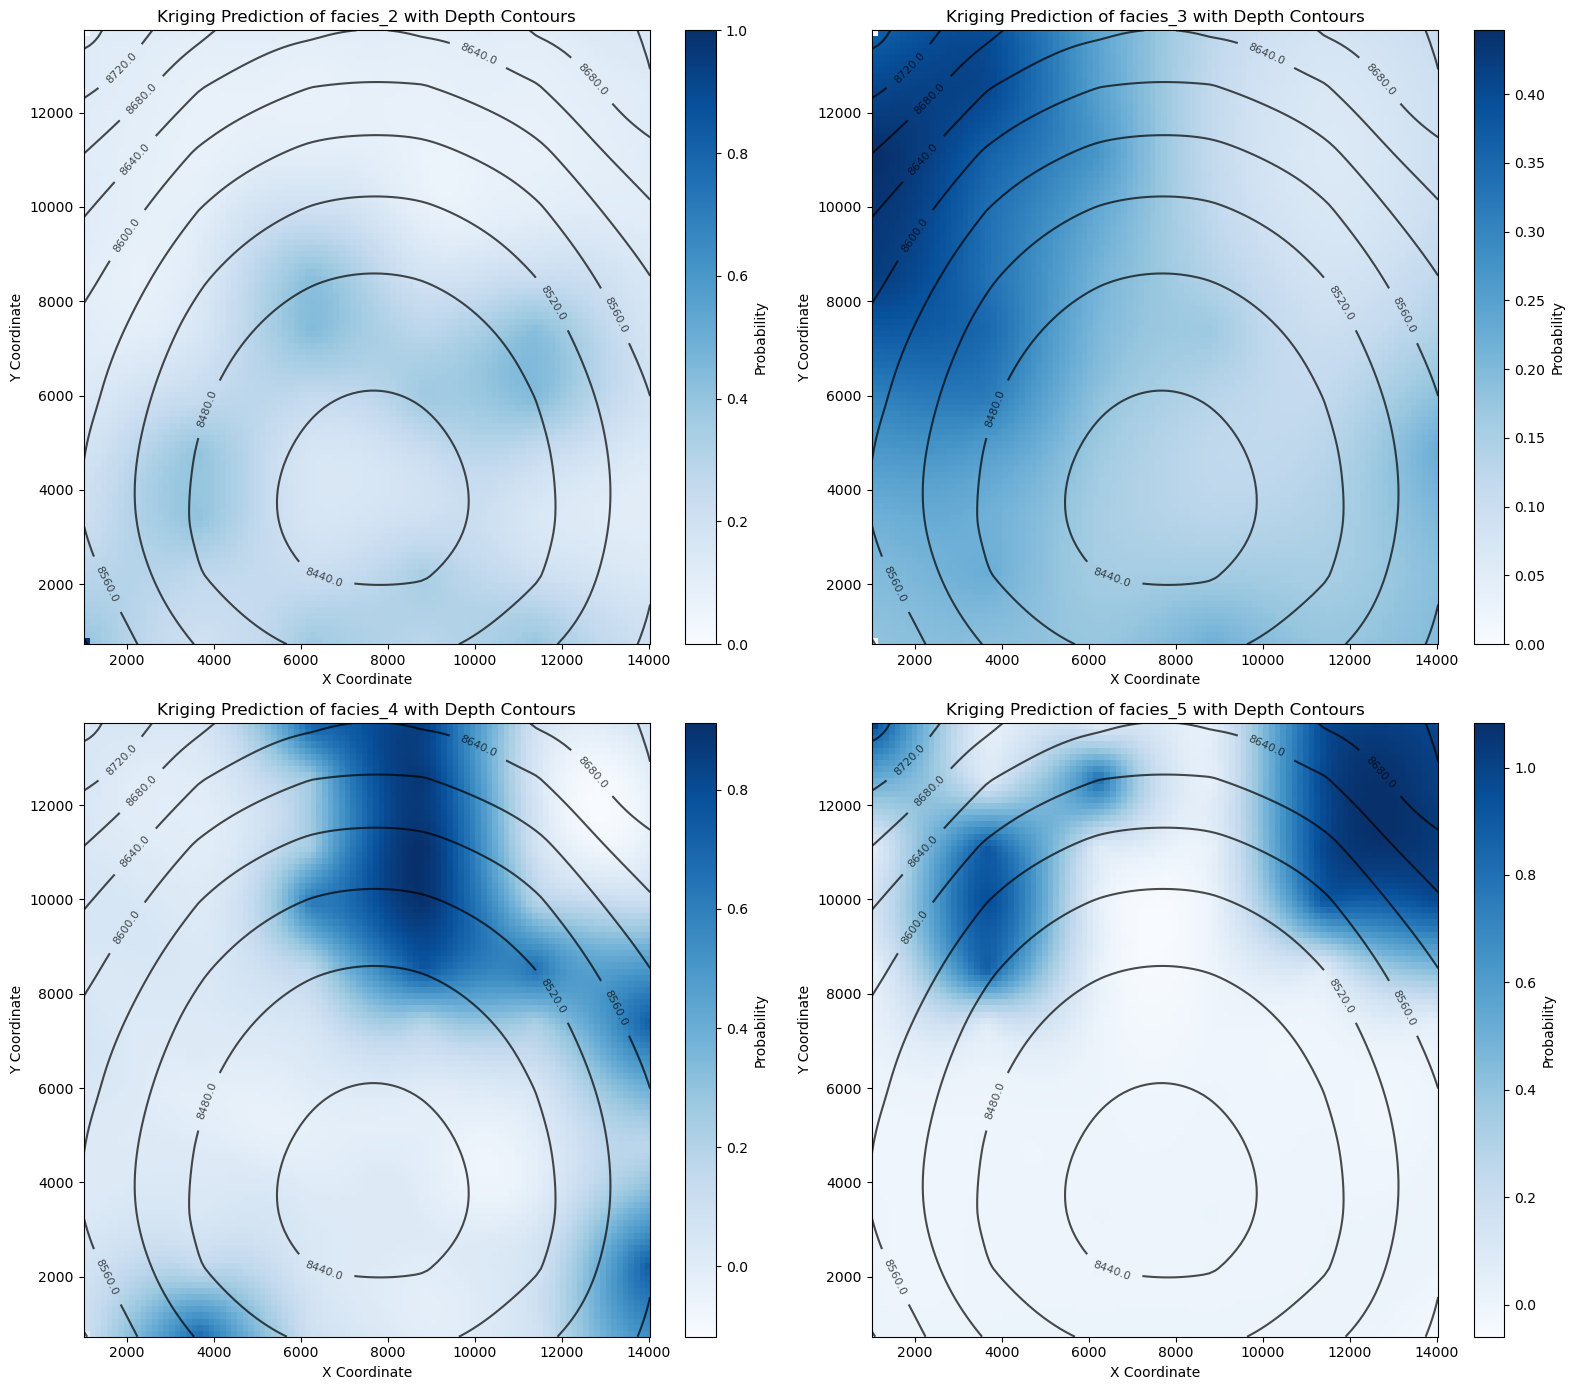

In [67]:
# For each facies dummy variable
facies_cols = ['facies_2', 'facies_3', 'facies_4', 'facies_5']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, facies in enumerate(facies_cols):
    x = df['bh_x'].values
    y = df['bh_y'].values
    z = df[facies].values
    
    # Remove NaN
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x_clean, y_clean, z_clean = x[mask], y[mask], z[mask]
    
    # Grid
    grid_x = np.linspace(x_clean.min(), x_clean.max(), 100)
    grid_y = np.linspace(y_clean.min(), y_clean.max(), 100)
    
    # Kriging for facies
    OK = OrdinaryKriging(x_clean, y_clean, z_clean, variogram_model='spherical',
                         verbose=False, enable_plotting=False)
    z_pred, ss = OK.execute('grid', grid_x, grid_y)
    
    # Plot facies
    im = axes[idx].imshow(z_pred.T, extent=[x_clean.min(), x_clean.max(), y_clean.min(), y_clean.max()],
                          origin='lower', cmap='Blues', aspect='auto')
    plt.colorbar(im, ax=axes[idx], label='Probability')
    
    # Add depth contours
    depth = df['total_depth_md'].values
    mask_depth = ~(np.isnan(x) | np.isnan(y) | np.isnan(depth))
    x_depth, y_depth, z_depth = x[mask_depth], y[mask_depth], depth[mask_depth]
    
    OK_depth = OrdinaryKriging(x_depth, y_depth, z_depth, variogram_model='spherical',
                               verbose=False, enable_plotting=False)
    depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)
    
    contours = axes[idx].contour(grid_x, grid_y, depth_pred.T, 
                                 colors='black', linewidths=1.5, levels=8, alpha=0.7)
    axes[idx].clabel(contours, inline=True, fontsize=8, fmt='%0.1f')
    
    axes[idx].set_xlabel('X Coordinate')
    axes[idx].set_ylabel('Y Coordinate')
    axes[idx].set_title(f'Kriging Prediction of {facies} with Depth Contours')

plt.tight_layout()
plt.show()


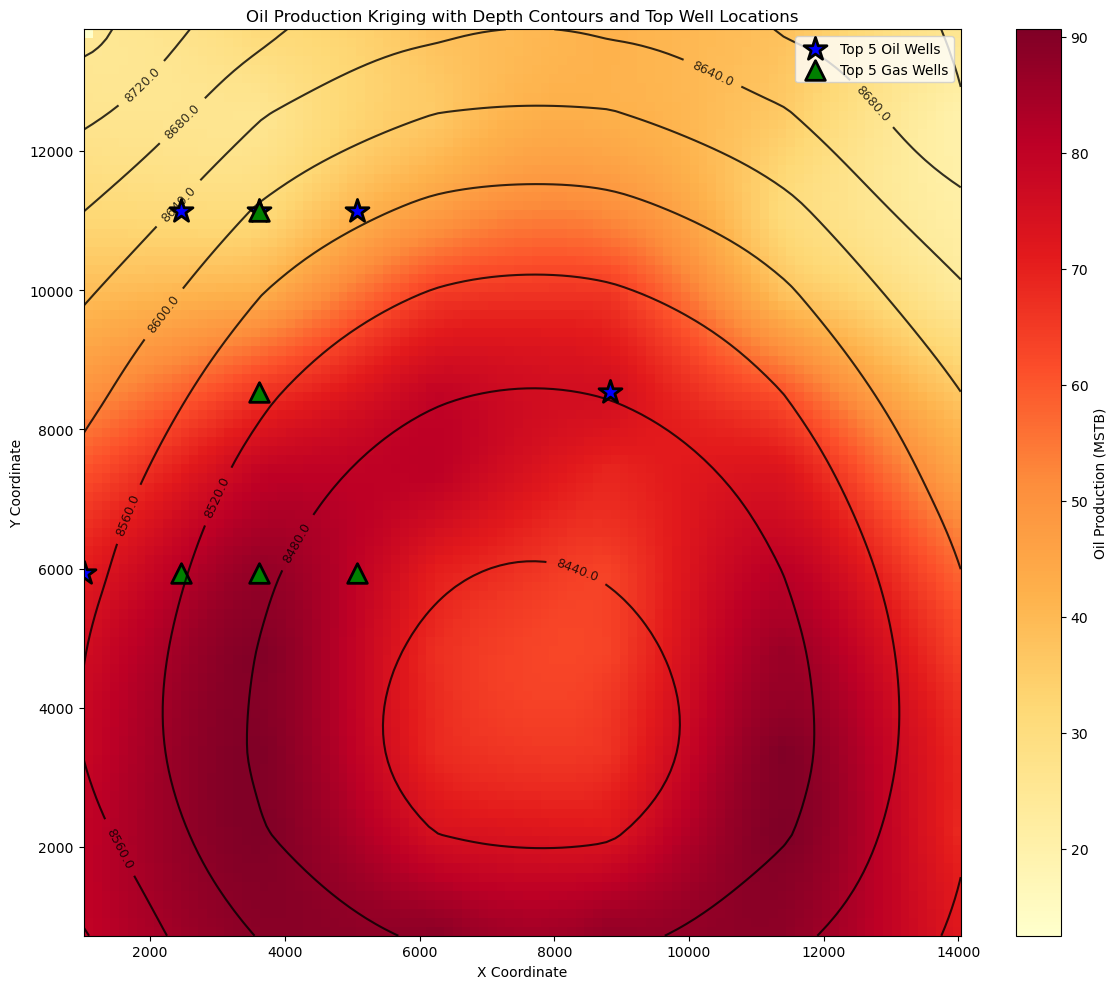

In [70]:
# Identify top wells
top_oil = df.nlargest(5, 'oil_prod_mstb')
top_gas = df.nlargest(5, 'gas_prod_mmcf')

# Create composite kriging plot with top wells marked
x = df['bh_x'].values
y = df['bh_y'].values
z = df['oil_prod_mstb'].values

mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
x, y, z = x[mask], y[mask], z[mask]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)

OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                     verbose=False, enable_plotting=False)
z_pred, ss = OK.execute('grid', grid_x, grid_y)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(z_pred.T, extent=[x.min(), x.max(), y.min(), y.max()],
               origin='lower', cmap='YlOrRd', aspect='auto')
plt.colorbar(im, ax=ax, label='Oil Production (MSTB)')

# Add depth contours
depth = df['total_depth_md'].values
x_all = df['bh_x'].values
y_all = df['bh_y'].values

mask_depth = ~(np.isnan(x_all) | np.isnan(y_all) | np.isnan(depth))
x_depth, y_depth, z_depth = x_all[mask_depth], y_all[mask_depth], depth[mask_depth]

OK_depth = OrdinaryKriging(x_depth, y_depth, z_depth, variogram_model='spherical',
                           verbose=False, enable_plotting=False)
depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)

contours = ax.contour(grid_x, grid_y, depth_pred.T, 
                      colors='black', linewidths=1.5, levels=8, alpha=0.8)
ax.clabel(contours, inline=True, fontsize=9, fmt='%0.1f')

# Overlay top wells
ax.scatter(top_oil['bh_x'], top_oil['bh_y'], c='blue', s=300, 
           marker='*', edgecolor='black', linewidth=2, label='Top 5 Oil Wells')
ax.scatter(top_gas['bh_x'], top_gas['bh_y'], c='green', s=200, 
           marker='^', edgecolor='black', linewidth=2, label='Top 5 Gas Wells')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Oil Production Kriging with Depth Contours and Top Well Locations')
ax.legend()
plt.tight_layout()
plt.show()


In [72]:

# Define target
df['target_production'] = df['oil_prod_mstb'] + (df['gas_prod_mmcf'] * 0.15)

# Features
feature_cols = ['porosity', 'perm_hm', 'total_depth_md', 'past_pressure'] + \
               ['facies_2', 'facies_3', 'facies_4', 'facies_5']

X = df[feature_cols]
y = df['target_production']

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X, y)

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(xgb_importance)

# Predict production potential
df['sweet_score_xgb'] = xgb_model.predict(X)

# Normalize
df['sweet_score_xgb'] = (df['sweet_score_xgb'] - df['sweet_score_xgb'].min()) / \
                         (df['sweet_score_xgb'].max() - df['sweet_score_xgb'].min())

# Cross-validation score
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validation R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


XGBoost Feature Importances:
          feature  importance
2  total_depth_md    0.392387
5        facies_3    0.278055
6        facies_4    0.180932
1         perm_hm    0.085461
0        porosity    0.062434
4        facies_2    0.000732
3   past_pressure    0.000000
7        facies_5    0.000000

Cross-validation R² scores: [ 0.609016   -0.3460711   0.61890074  0.68825642  0.59458678]
Mean R²: 0.433 (+/- 0.391)


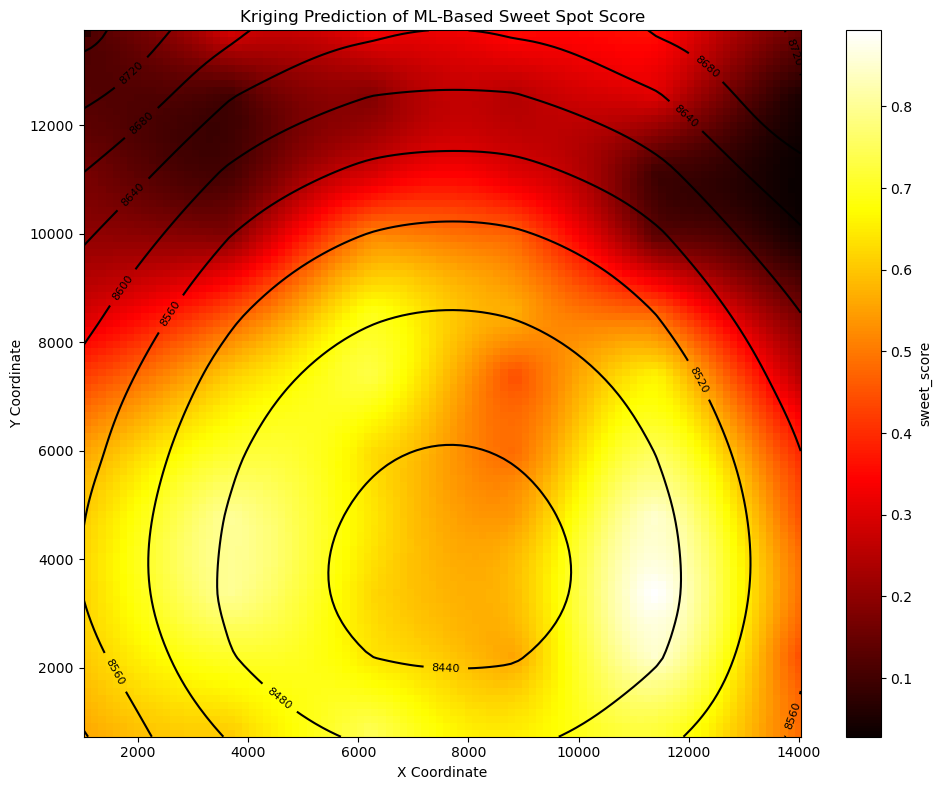


Top 10 ML-Predicted Sweet Spots:
       bh_x      bh_y  oil_prod_mstb  gas_prod_mmcf  porosity   perm_hm  \
12  3617.17  11141.88       120.7430     455.032070  0.188017  0.056463   
11  5064.04  11141.88       113.9040     424.497427  0.184044  0.050873   
13  2459.67  11141.88       113.8510     417.537157  0.185201  0.052861   
47  3617.17   3328.80       105.3550     389.044408  0.176190  0.041674   
48  5064.04   3328.80       112.4416     337.495037  0.176578  0.042639   
35  1012.81   5933.16       116.3390     281.897025  0.174661  0.038392   
33  7668.40   5933.16       105.4785     326.459487  0.171049  0.036493   
10  6221.53  11141.88       104.8875     307.768120  0.161975  0.038947   
34  8825.89   5933.16       108.6708     246.102413  0.162714  0.030338   
14  7668.40  11141.88       102.9649     283.457877  0.168665  0.037831   

    sweet_score  
12     1.000000  
11     0.940927  
13     0.936205  
47     0.866176  
48     0.866176  
35     0.842947  
33     0.81904

In [73]:
df['sweet_score'] = df['sweet_score_xgb']

# Create kriging plot
create_kriging_plot(df, 'bh_x', 'bh_y', 'sweet_score', 
                    'Kriging Prediction of ML-Based Sweet Spot Score',
                    cmap='hot', add_contours=True, contour_col='total_depth_md')
plt.show()

# Identify top sweet spots
top_sweet_spots = df.nlargest(10, 'sweet_score')[
    ['bh_x', 'bh_y', 'oil_prod_mstb', 'gas_prod_mmcf', 
     'porosity', 'perm_hm', 'sweet_score']
]

print("\nTop 10 ML-Predicted Sweet Spots:")
print(top_sweet_spots)